## 2012.1.1 - 2017.9.2 Baltimore Victim-Based Crime exploratory data analysis


In [1]:
# Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

In [2]:
# read in kaggle 2012-2017 dataset
df = pd.read_csv("Resources/2012-2017_BPD_Victim_Based_Crime_Data.csv")
df.head()

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,Total Incidents
0,09/02/2017,23:30:00,3JK,4200 AUDREY AVE,ROBBERY - RESIDENCE,I,KNIFE,913.0,SOUTHERN,Brooklyn,-76.60541,39.22951,"(39.2295100000, -76.6054100000)",ROW/TOWNHO,1
1,09/02/2017,23:00:00,7A,800 NEWINGTON AVE,AUTO THEFT,O,NaN,133.0,CENTRAL,Reservoir Hill,-76.63217,39.31360,"(39.3136000000, -76.6321700000)",STREET,1
2,09/02/2017,22:53:00,9S,600 RADNOR AV,SHOOTING,Outside,FIREARM,524.0,NORTHERN,Winston-Govans,-76.60697,39.34768,"(39.3476800000, -76.6069700000)",Street,1
3,09/02/2017,22:50:00,4C,1800 RAMSAY ST,AGG. ASSAULT,I,OTHER,934.0,SOUTHERN,Carrollton Ridge,-76.64526,39.28315,"(39.2831500000, -76.6452600000)",ROW/TOWNHO,1
4,09/02/2017,22:31:00,4E,100 LIGHT ST,COMMON ASSAULT,O,HANDS,113.0,CENTRAL,Downtown West,-76.61365,39.28756,"(39.2875600000, -76.6136500000)",STREET,1


## Data cleaning and preparation

Post and CrimeCode dropped. Inside/Ouside cleaned. "Time of Day" and "Day of Week" series added. No null values have been dropped (for example, there are 10,000 nulls in "Inside/Outside", or 3% of the data). 


In [3]:
# data cleaning and organization

# remove series
df.drop(columns=["CrimeCode", "Post"], inplace=True)

# consolidate Inside/Outside values, merging "O" and "I" with "Outside" and "Inside"
df["Inside/Outside"] = df["Inside/Outside"].replace({"Outside": "O", "Inside": "I"})

# convert day to datetime data type
df.CrimeDate = pd.to_datetime(df.CrimeDate)

# change midnight for to_datetime
# create temp series CrimeTimeTemp for splitting data into Time of Day
df.loc[df.CrimeTime == "24:00:00", "CrimeTime"] = "00:00:00"
df["CrimeTimeTemp"] = pd.to_datetime(df.CrimeTime, format="%H:%M:%S")

# create bins and labels for morning, afternoon, evening, late night
# -1 because it kept populating "Time of Day" with NaN for any 0 hours (12am)
bins = [-1, 6, 12, 18, 24]
labels = ["Late Night", "Morning", "Afternoon", "Evening"]

# pd.cut likes ints, so dt.hour extracts the hour for comparison with bins
# remove CrimeTimeTemp from the df
df["Time of Day"] = pd.cut(
    df.CrimeTimeTemp.dt.hour, bins=bins, labels=labels
)
df.drop(columns=["CrimeTimeTemp"], inplace=True)

# add 'Day of Week' series
df["Day of Week"] = df["CrimeDate"].dt.day_name()


In [4]:
df

,CrimeDate,CrimeTime,Location,Description,Inside/Outside,Weapon,District,Neighborhood,Longitude,Latitude,Location 1,Premise,Total Incidents,Time of Day,Day of Week
0,2017-09-02,23:30:00,4200 AUDREY AVE,ROBBERY - RESIDENCE,I,KNIFE,SOUTHERN,Brooklyn,-76.60541,39.22951,"(39.2295100000, -76.6054100000)",ROW/TOWNHO,1,Evening,Saturday
1,2017-09-02,23:00:00,800 NEWINGTON AVE,AUTO THEFT,O,NaN,CENTRAL,Reservoir Hill,-76.63217,39.31360,"(39.3136000000, -76.6321700000)",STREET,1,Evening,Saturday
2,2017-09-02,22:53:00,600 RADNOR AV,SHOOTING,O,FIREARM,NORTHERN,Winston-Govans,-76.60697,39.34768,"(39.3476800000, -76.6069700000)",Street,1,Evening,Saturday
3,2017-09-02,22:50:00,1800 RAMSAY ST,AGG. ASSAULT,I,OTHER,SOUTHERN,Carrollton Ridge,-76.64526,39.28315,"(39.2831500000, -76.6452600000)",ROW/TOWNHO,1,Evening,Saturday
4,2017-09-02,22:31:00,100 LIGHT ST,COMMON ASSAULT,O,HANDS,CENTRAL,Downtown West,-76.61365,39.28756,"(39.2875600000, -76.6136500000)",STREET,1,Evening,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276524,2012-01-01,00:00:00,1400 JOH AVE,LARCENY,I,NaN,SOUTHWESTERN,Violetville,-76.67195,39.26132,"(39.2613200000, -76.6719500000)",OTHER - IN,1,Late Night,Sunday
276525,2012-01-01,00:00:00,5500 SINCLAIR LN,LARCENY,O,NaN,NORTHEASTERN,Frankford,-76.53829,39.32493,"(39.3249300000, -76.5382900000)",OTHER - OU,1,Late Night,Sunday
276526,2012-01-01,00:00:00,400 N PATTERSON PK AV,LARCENY,O,NaN,EASTERN,CARE,-76.58497,39.29573,"(39.2957300000, -76.5849700000)",STREET,1,Late Night,Sunday
276527,2012-01-01,00:00:00,5800 LILLYAN AV,BURGLARY,I,NaN,NORTHEASTERN,Glenham-Belhar,-76.54578,39.34701,"(39.3470100000, -76.5457800000)",APT. LOCKE,1,Late Night,Sunday


## Initial visualizations

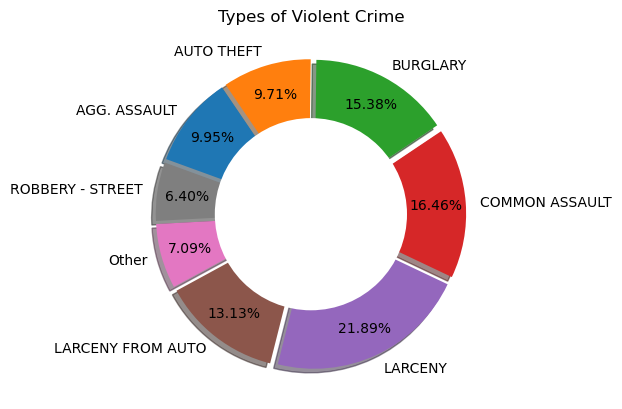

In [7]:
# pie chart of types of victim-based crime

#create temporary data frame of value counts for types of crime
desc_df = df.Description.value_counts()
desc_df = desc_df.to_frame().reset_index()
desc_df.rename(columns={'index': 'Description', 'Description': 'count'}, inplace=True)

# condense small values into a single 'Other' category
small_values = (desc_df['count'] /len(df)) < .05
desc_df.loc[small_values, 'Description'] = 'Other'
desc_df = desc_df.groupby('Description')['count'].sum()

# plot the pie chart
plt.pie(
    desc_df.values,
    labels=desc_df.index,
    explode=(0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05),
    shadow=True,
    startangle=160,
    autopct="%1.2f%%",
    pctdistance=0.8,
    counterclock=False,
)

plt.title("Types of Violent Crime")

# gcf get current figure, gca get current axis
donut = plt.Circle((0, 0), 0.65, facecolor="white")
plt.gcf().gca().add_artist(donut)

plt.show()

## Question - Crime by Hour vs various indicators

    Katie - scatter plot of crime by Hour, add a line for each day of the week

    Bryan - line chart of number of crimes per year, categorized by time of day (late night, morning, afternoon, evening)

    Siobhan - rework Katie's scatter plot of crime by hour to make a line for each description of crime
    
    statistical test (ANOVA, t-test, or chi-square)

## Question - Crime by Day of Week vs various indicators

    Rob - crime by day of week / scatter plot (or line plot) of crime by hour, but with a line for each year

    Rob - crime description by day of week
    
    statistical test (ANOVA, t-test, or chi-square)

## Question - Crime by Year

    Siobhan - ?Stacked? Bar plot of crime Description by year

    Bryan - plot of crime for each year (by month, instead of day - ?mention Freddie Grey?)
    
    statistical test (ANOVA, t-test, or chi-square)